# Modeling Data & Making Predictions

Here we can load the saved dataframes and added each one into a list. We will create a baseline model, generate forecasts on the test period, store forecasts and MSE for each zipcode. We will also view the average MSE.

We will start by creating a baseline model for each zipcode. We will plot the test period of the last twelve months.

# Importing Libraries

We will use the following libraries for this project:

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import time

# Loading Zillow Data

In [2]:
df = pd.read_csv('zillow_data.csv')

# Defining list of dataframes for each state.
states = df['State'].unique()
state_df = []
for state in states:
    state_df.append(df[df['State']==state].copy())

# Defining dataframe for Houston zipcodes 
houston = state_df[1][state_df[1]['City'] == 'Houston'].copy()
houston.set_index(keys='RegionName',inplace=True)

# Creating dataframe of zipcodes by average price and viewing top three
houston_zips_by_mean = pd.DataFrame(houston.iloc[:, 6:-1].mean(axis=1), columns=['Mean'])
houston_zips = houston_zips_by_mean.index 

# Modeling Data

In [3]:
loaded_houston_dfs = []
for o in houston_zips:
    loaded_zip = pd.read_csv(f'{o}.csv')
    loaded_houston_dfs.append(loaded_zip)

In [6]:
test_period = 12
zip_dfs = []
models = []
start = time.time()

for e in loaded_houston_dfs:
    e.index = pd.to_datetime(e.variable,format="%Y-%m")
    e.drop('variable',axis=1,inplace=True)
    ## month and day features
    e['Month'] = e.index.month
    e['Day'] = e.index.dayofyear
    e['Year'] = e.index.year - e.index.year.min()
    date_features = ['Month','Year']
    ## month and day polynomials
    polynomial_terms = [2,3]
    for feature in date_features:
        for i in polynomial_terms:
            e[feature+'**'+str(i)] = e[feature]**i
    ## previous values and polynomials
    previous_values_range = 36
    for i in range(1,previous_values_range):
        e['Previous'+str(i)] = e['value'].shift(i).bfill()
        for j in polynomial_terms:
            e['Previous'+str(i)+'**'+str(j)] = (e['value'].shift(i).bfill())**j
    ## fit model
    reg = LassoLarsCV(cv=5).fit(e.drop(['value'],axis=1)[:-test_period], e['value'][:-test_period])
    zip_dfs.append(e)
    models.append(reg)
print('Time:', time.time()-start, 'seconds.')

Time: 57.049630880355835 seconds.


Now that we have the baseline models: 
- We can generate forecasts on the test period, 
- Store forecast dataframes, 
- Save the MSE for each model, 
- and view average MSE across all zipcodes. 

In [13]:
forecast_dfs = []
start = time.time()
mses = []
for model, df_,z in zip(models, zip_dfs, houston_zips):
    actual = df_[-test_period:]['value']
    forecast = []
    ## create and populate forecast dataframe
    forecast_df = df_.copy()
    for datetime, date in zip(df_.index[-test_period:], range(len(df_)-test_period, len(df_))):
        values = []
        ## add datetime components
        values.append(datetime.month)
        values.append(datetime.dayofyear)
        values.append(datetime.year - (df_.index.year.min()))
        ## add polynomial terms of datetime components
        for feature in date_features:
            for i in polynomial_terms:
                values.append((forecast_df[feature][date])**i)
        ## add previous values and polynomial terms of previous values
        for i in range(1,previous_values_range):
            values.append(forecast_df['value'][date-i])
            for j in polynomial_terms:
                values.append((forecast_df['value'][date-i])**j)
        ## make prediction on current datetime
        forecast_ = model.predict(np.array(values).reshape(1,-1))[0]
        forecast.append(forecast_)
        ## append prediction to start of values array
        values.insert(0, forecast_)
        ## set forecast row in dataframe
        forecast_df.loc[datetime] = values
    forecast_dfs.append(forecast)
    # Saving the forecast dataframes
    mses.append(np.mean(np.abs(actual - forecast)**2))
print('Time:', time.time()-start, 'seconds.')
print('Average MSE:', np.average(mses))

Time: 22.91410803794861 seconds.
Average MSE: 6.338836177451639e+80


In [64]:
print('Min MSE: '+'$'+ str(round(max([np.sqrt(i) for i in mses]),2)))
print('Max MSE: '+ '$'+ str(round(min([np.sqrt(i) for i in mses]),2)))
print('Average MSE: '+ '$'+ str(round(np.average([np.sqrt(i) for i in mses]),2))) # removed outlier from average

Min MSE: $2.3348231437538066e+41
Max MSE: $906.91
Average MSE: $2.714910632271868e+39


- Here we will plot predictions vs actual values for each zipcode, along with the MSE.

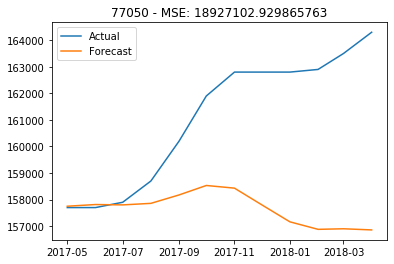

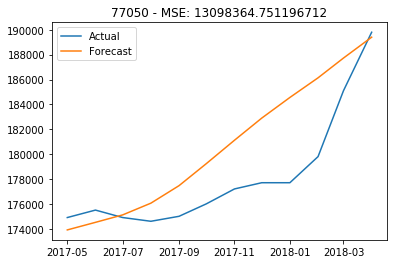

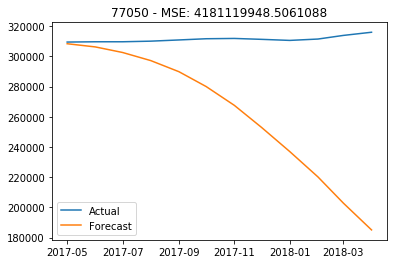

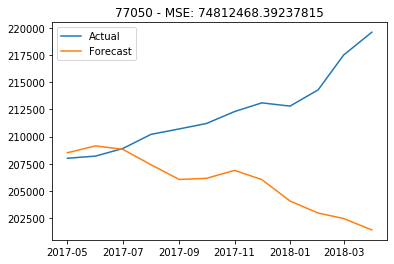

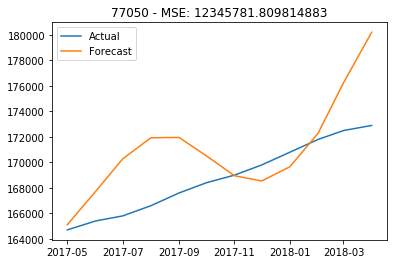

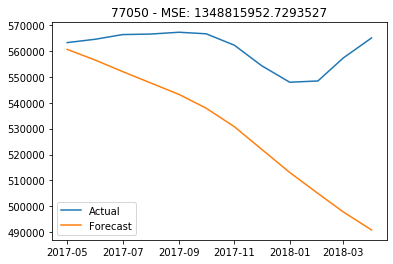

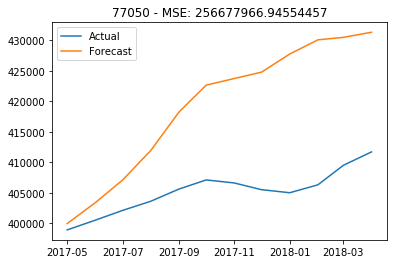

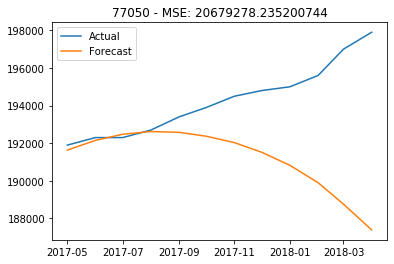

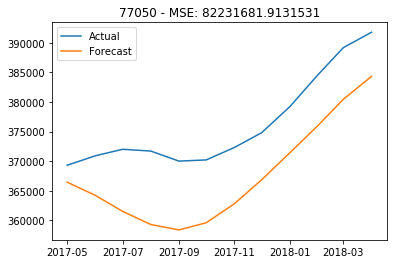

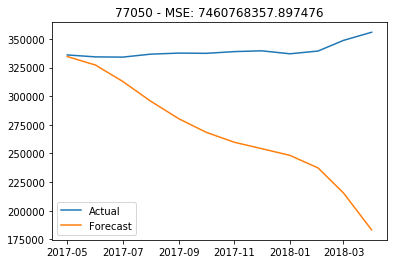

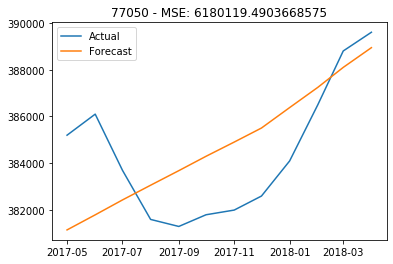

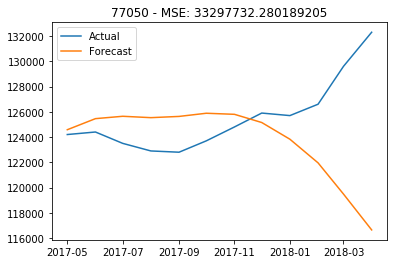

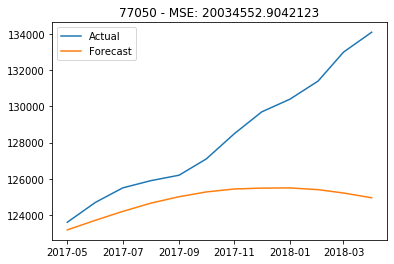

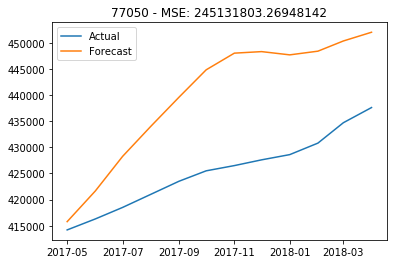

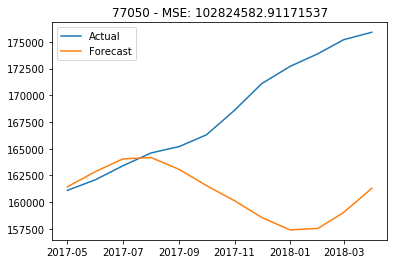

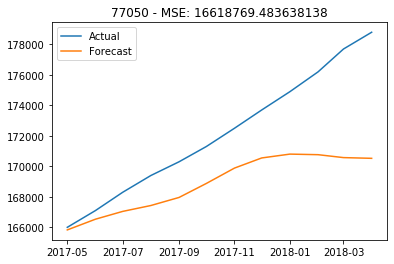

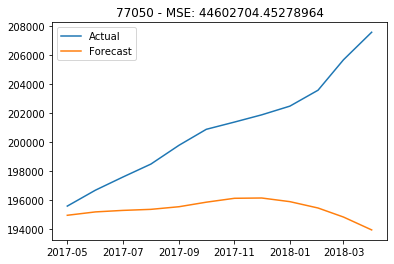

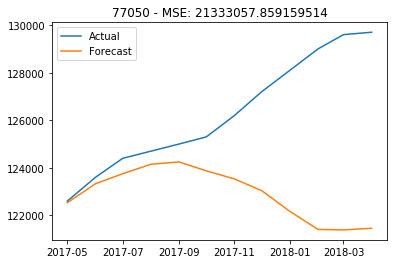

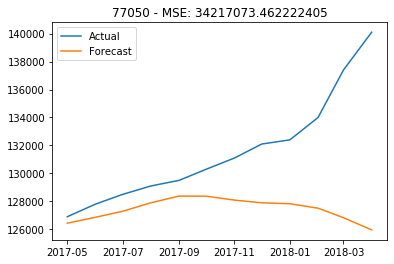

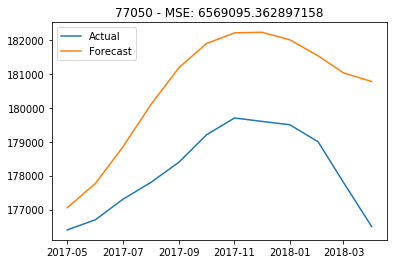

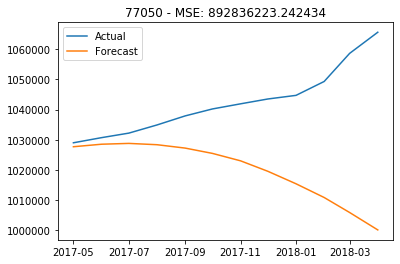

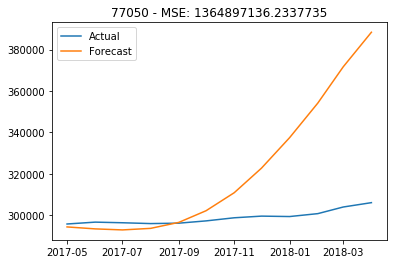

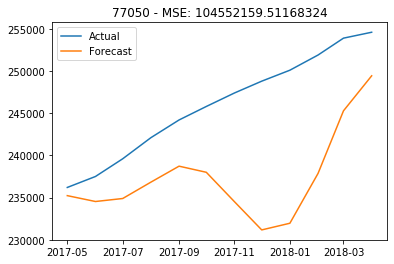

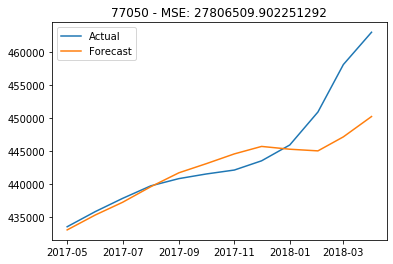

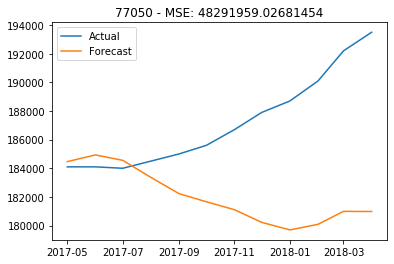

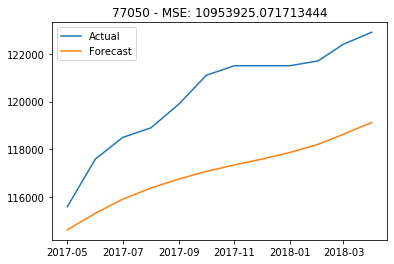

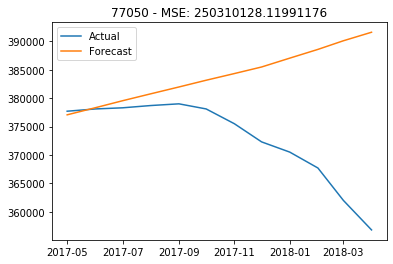

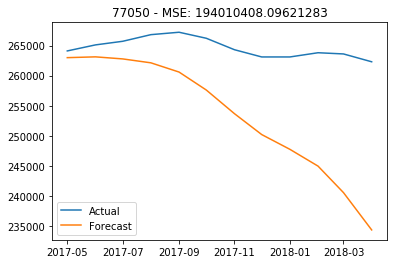

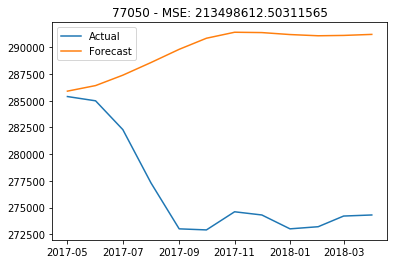

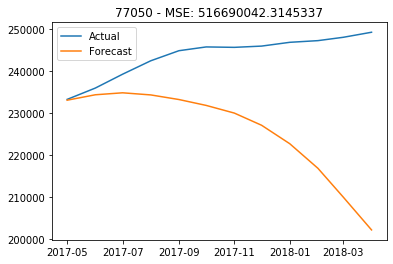

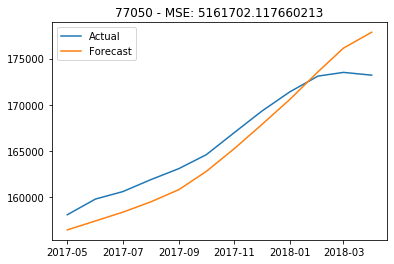

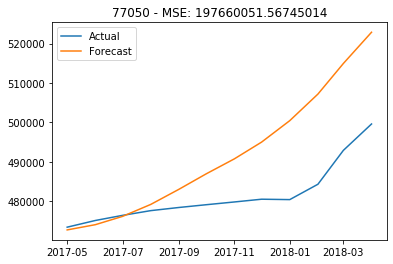

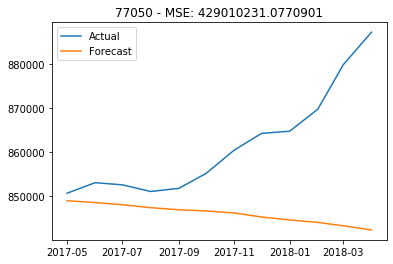

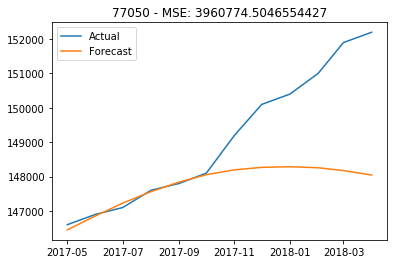

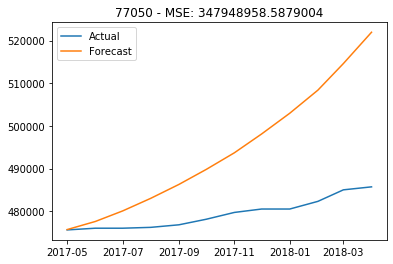

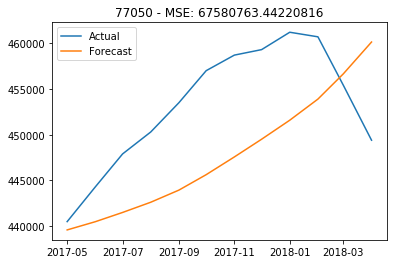

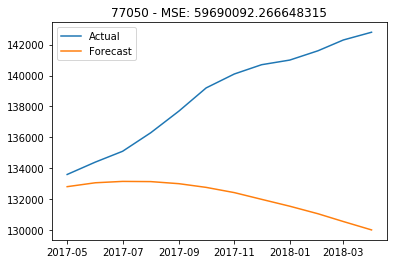

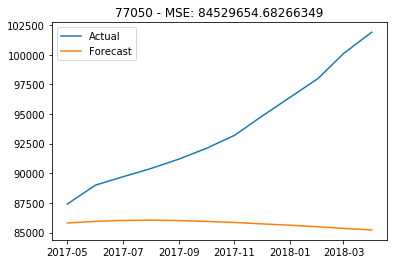

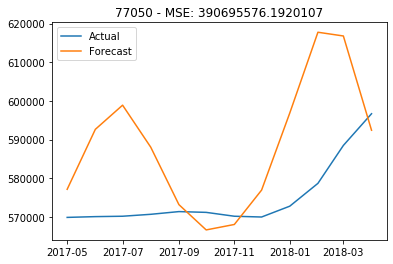

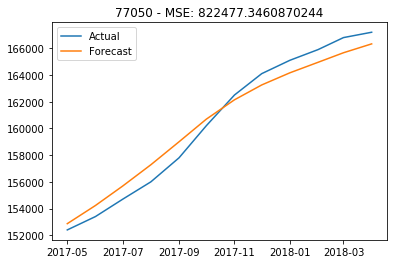

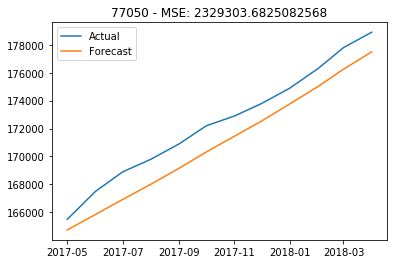

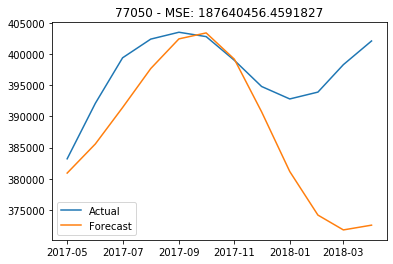

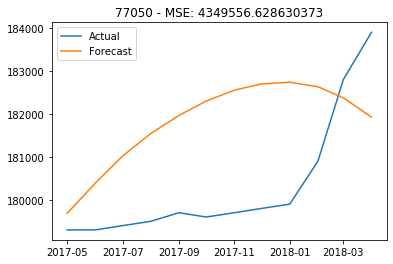

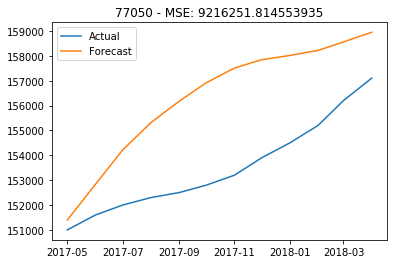

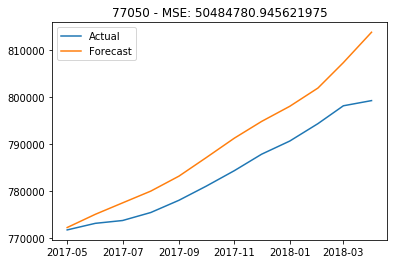

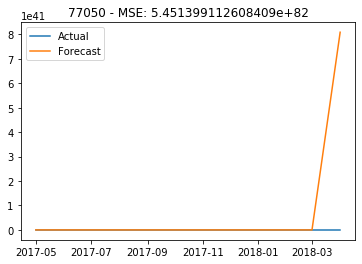

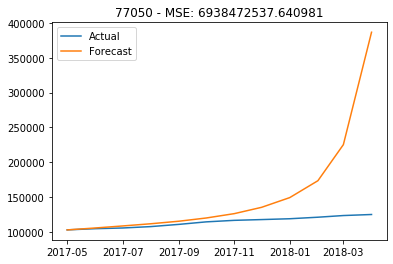

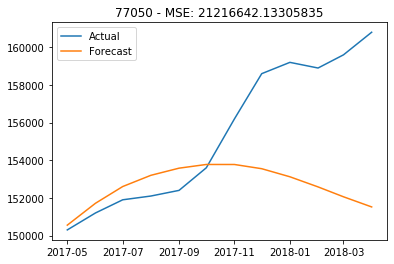

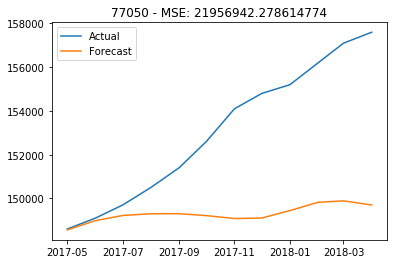

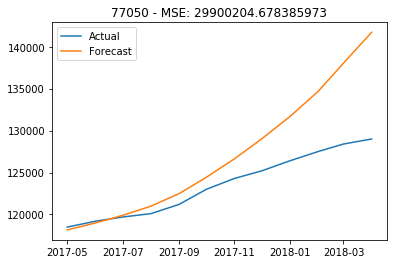

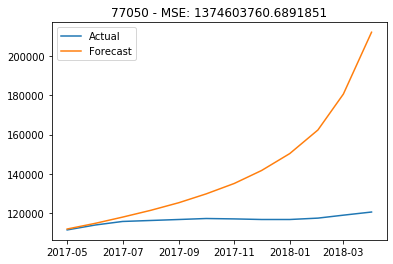

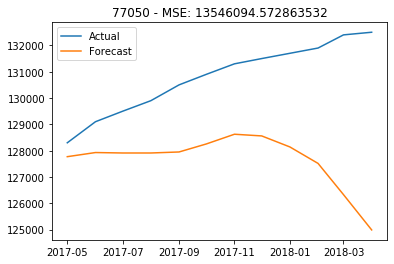

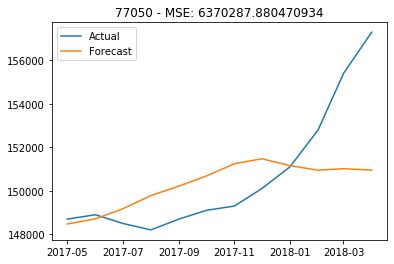

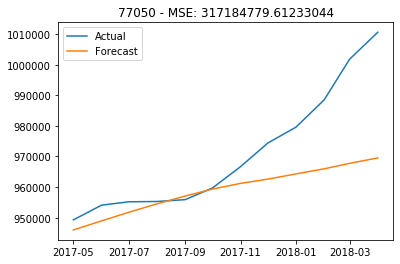

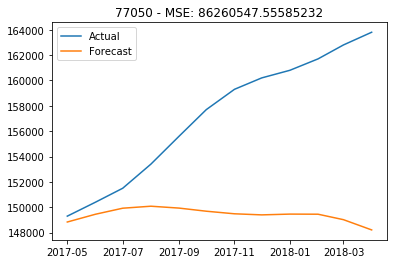

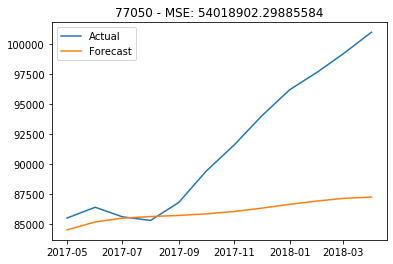

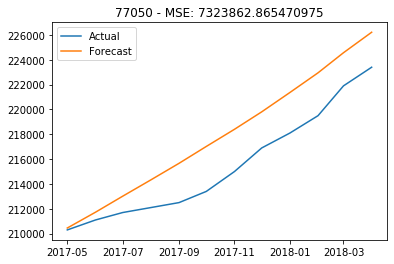

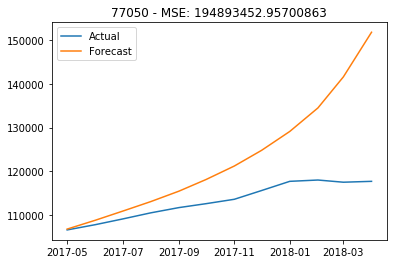

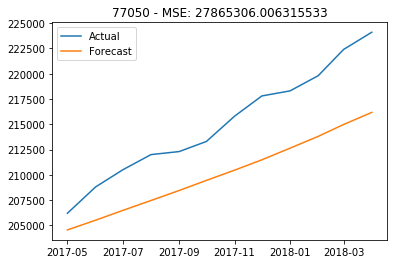

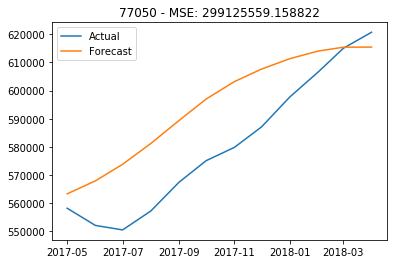

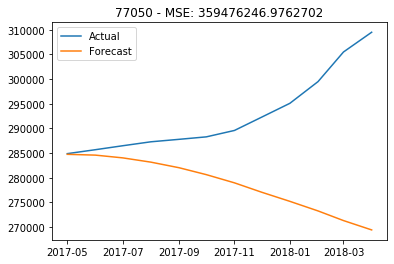

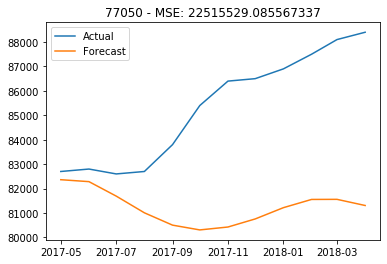

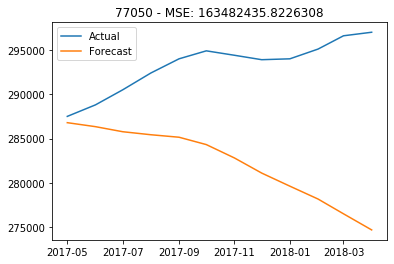

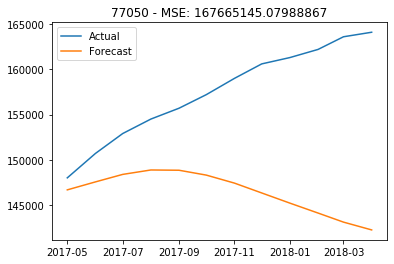

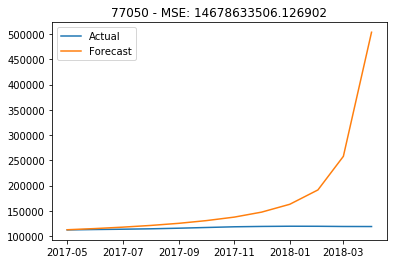

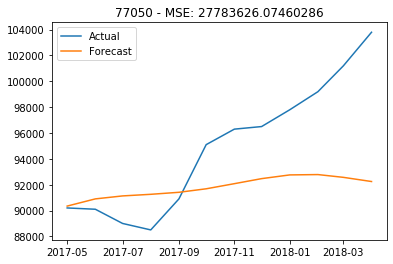

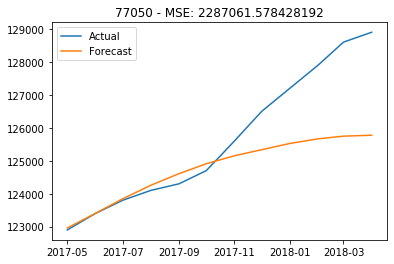

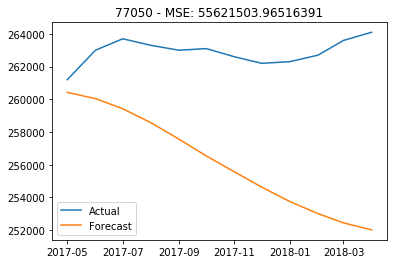

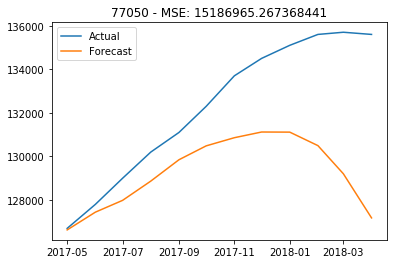

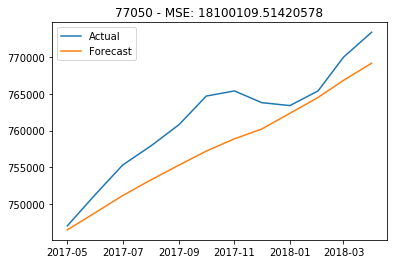

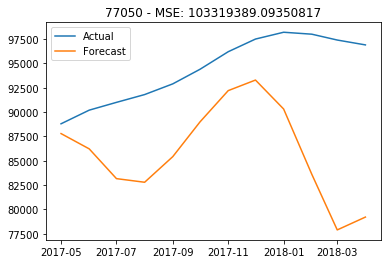

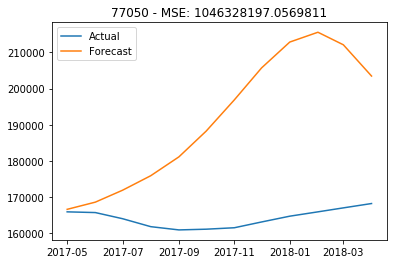

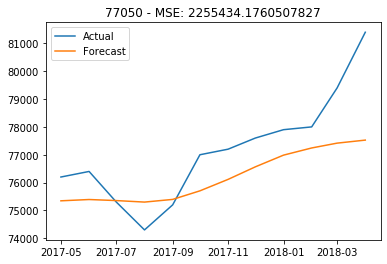

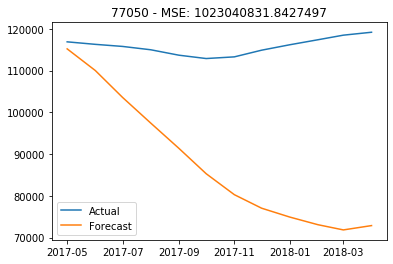

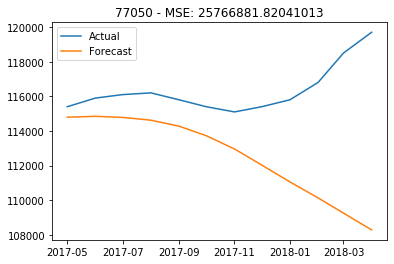

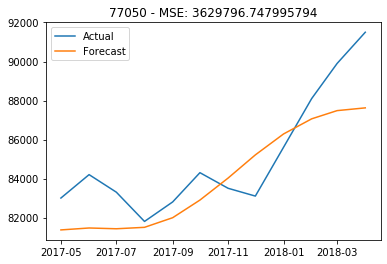

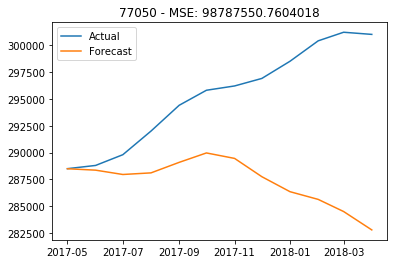

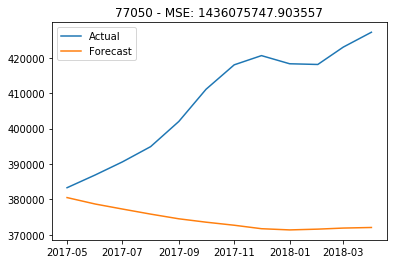

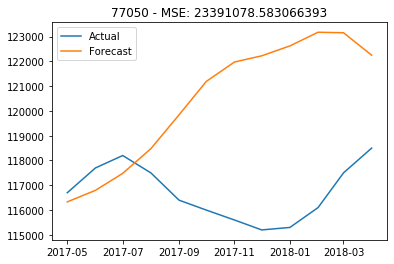

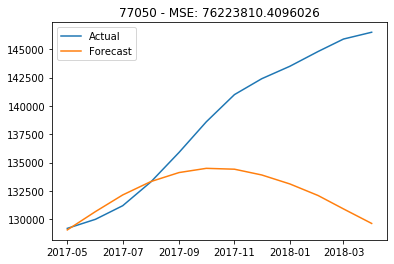

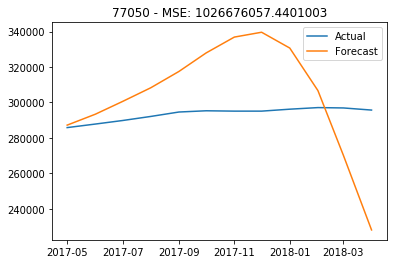

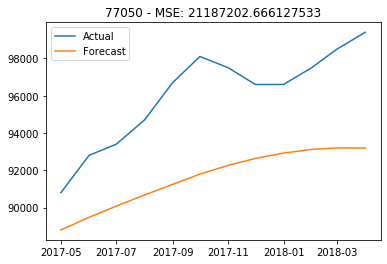

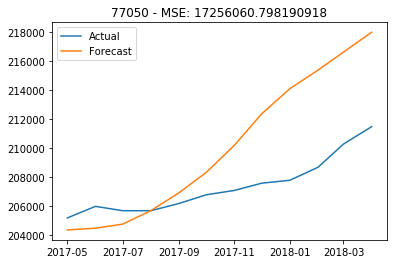

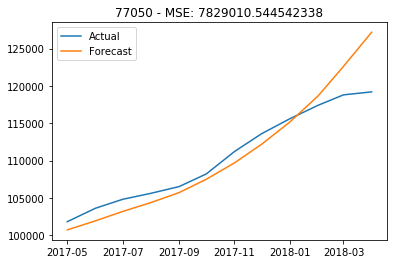

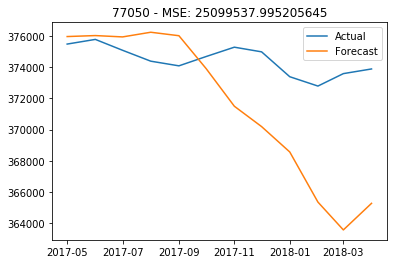

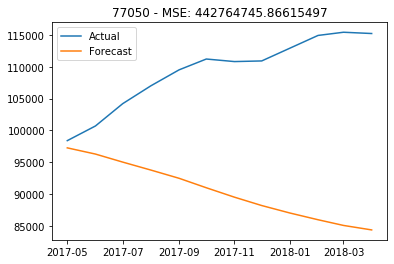

In [15]:
for df_, y_hat, mSe in zip(zip_dfs, forecast_dfs, mses):
    plt.plot(df_[-test_period:].index, df_[-test_period:]['value'])
    plt.plot(df_[-test_period:].index, y_hat)
    plt.legend(['Actual', 'Forecast'])
    plt.title(str(z)+' - MSE: '  + f'{mSe}')
    plt.show();

## View features selected

- Below we can view the selected features for each zipcode's models.

In [16]:
for i,z in zip(models,houston_zips): 
    selected_features = pd.DataFrame()
    selected_features['Feature'] = zip_dfs[0].drop('value',axis=1).columns[i.coef_>0]
    selected_features['Coefficient'] = i.coef_[i.coef_>0]
    selected_features.sort_values('Coefficient')
    print(z)
    print(selected_features)
    print('--------------------------------')

77084
          Feature   Coefficient
0           Month  1.062115e+01
1        Month**3  1.232684e-01
2         Year**3  1.281011e-01
3       Previous1  2.047915e+00
4    Previous3**3  9.666486e-12
5    Previous6**2  5.017703e-07
6       Previous8  1.241404e-02
7    Previous8**2  4.159424e-07
8   Previous13**3  1.470582e-12
9      Previous19  5.903624e-02
10  Previous19**3  3.831611e-13
11  Previous23**3  1.218310e-14
12  Previous24**3  6.699603e-13
13     Previous25  5.385753e-02
14  Previous25**3  1.502466e-12
15  Previous28**3  1.181350e-13
16  Previous29**3  1.054849e-12
17     Previous34  4.730717e-02
--------------------------------
77036
         Feature   Coefficient
0          Month  9.413638e+00
1           Year  8.733432e+00
2        Year**3  5.233495e-02
3      Previous1  1.647298e+00
4   Previous4**3  1.700112e-13
5  Previous13**3  1.306652e-12
6  Previous21**3  4.152302e-14
7     Previous24  1.552170e-02
--------------------------------
77077
          Feature   Coefficie

77345
          Feature   Coefficient
0           Month  1.055873e+01
1            Year  7.545969e+01
2         Year**3  1.583727e-01
3       Previous1  1.791725e+00
4    Previous4**3  1.042943e-13
5    Previous9**3  3.300118e-13
6      Previous13  1.616273e-03
7   Previous13**3  6.212865e-13
8   Previous14**3  1.944976e-13
9   Previous19**3  8.572437e-14
10  Previous25**3  6.766177e-14
11  Previous28**3  1.565853e-13
12     Previous35  1.136734e-02
--------------------------------
77061
         Feature   Coefficient
0       Month**3  1.251864e-02
1        Year**3  7.315441e-02
2      Previous1  1.440157e+00
3   Previous1**2  8.830071e-07
4     Previous14  3.836868e-03
5  Previous14**2  2.470448e-07
6  Previous23**3  3.863314e-13
7  Previous24**3  3.548678e-13
--------------------------------
77053
          Feature   Coefficient
0             Day  1.249348e-01
1         Year**3  3.177249e-02
2       Previous1  9.608300e-01
3    Previous1**3  2.370391e-11
4       Previous4  5.996680e-

## Predicting Future Prices and Fitting the Model to Entire Dataset

In [17]:
start = time.time()
todays = []
days = []
futures = []

# datetime = pd.to_datetime('2018-05-01',format="%Y-%m-%d")
for df_,zzz in zip(zip_dfs,houston_zips):
    print(f'Forecasting prices for zipcode : {zzz}')
    tomorrows = []
    date_times_ = []
    todays.append(df_['value'][-1])
    df___s = pd.DataFrame(columns=df_.columns)
    for datetime, date in zip(pd.Series([i + pd.offsets.BMonthBegin() for i in pd.date_range('2018-04-1', freq='3M', periods=11)]), 
                              range(len(df_.values[-1]),len(df_)+12)):
        nxt_month_date = len(df_)
        ## fit final model to entire dataset
        model = LassoLarsCV(cv=5).fit(df_.drop(['value'],axis=1), df_['value'])
        values = []
        ## add datetime components
        values.append(datetime.month)
        values.append(datetime.dayofyear)
        values.append(datetime.year - (df_.index.year.min()))
        ## add polynomial terms of datetime components
        for feature in date_features:
            for i in polynomial_terms:
                values.append((df_[feature][date])**i)
        ## add previous values and polynomial terms of previous values
        for i in range(1,previous_values_range):
            values.append(df_['value'][date-i])
            for j in polynomial_terms:
                values.append((df_['value'][date-i])**j)
        ## make prediction on current datetime
        forecast = model.predict(np.array(values).reshape(1,-1))[0]
        new_vals = values.insert(0,forecast)
        date_times_.append(datetime)
        tomorrows.append(forecast)
        df__ = pd.DataFrame(np.array(values).reshape(1,-1),columns=df_.columns,index=[datetime])
        df___s = df___s.append(df__.loc[datetime])
        df_ = df_.append(df___s.loc[datetime],ignore_index=False)
        date_times_.append(datetime)
        tomorrows.append(forecast)
    days.append(date_times_)
    futures.append(tomorrows)
print(time.time() - start)

Forecasting prices for zipcode : 77084
Forecasting prices for zipcode : 77036
Forecasting prices for zipcode : 77077
Forecasting prices for zipcode : 77095
Forecasting prices for zipcode : 77082
Forecasting prices for zipcode : 77057
Forecasting prices for zipcode : 77007
Forecasting prices for zipcode : 77070
Forecasting prices for zipcode : 77081
Forecasting prices for zipcode : 77063
Forecasting prices for zipcode : 77042
Forecasting prices for zipcode : 77072
Forecasting prices for zipcode : 77015
Forecasting prices for zipcode : 77008
Forecasting prices for zipcode : 77040
Forecasting prices for zipcode : 77089
Forecasting prices for zipcode : 77339
Forecasting prices for zipcode : 77088
Forecasting prices for zipcode : 77099
Forecasting prices for zipcode : 77090
Forecasting prices for zipcode : 77024
Forecasting prices for zipcode : 77004
Forecasting prices for zipcode : 77080
Forecasting prices for zipcode : 77055
Forecasting prices for zipcode : 77044
Forecasting prices for zi

## Creating Dateframe of Predictions

In [19]:
predictions = pd.DataFrame()
predictions['Zip'] = houston_zips
predictions['This Month'] = todays
display(predictions)
for i, j in zip(days,futures):
    for x,y in zip(i,j):
        predictions[f"ROI by {x.date()}"] = y - predictions['This Month']

print('Predictions Preview:')
predictions.set_index('Zip',inplace=True)
display(predictions.head(3))

print('Current Price')
current = predictions[predictions.columns[:1]].mean(axis = 1, skipna = True) 
results = pd.DataFrame(current, copy = True,columns=['Current'])
display(results.head(3))

print('By Long Term ROI: ')
display(predictions[predictions.columns[1:]])
longterm = predictions[predictions.columns[1:]].mean(axis = 1, skipna = True)
results2 = pd.DataFrame(longterm, copy = True,columns=['LongTerm'])
display(results2.head(3))

print('By Mid Term ROI: ')
display(predictions[predictions.columns[1:-4]])
midterm = predictions[predictions.columns[1:-4]].mean(axis = 1, skipna = True)
results3 = pd.DataFrame(midterm, copy = True,columns=['MidTerm'])
display(results3.head(3))

print('By Short Term ROI')
display(predictions[predictions.columns[1:-8]])
shortterm = predictions[predictions.columns[1:-8]].mean(axis = 1, skipna = True)
results4 = pd.DataFrame(shortterm, copy = True,columns=['ShortTerm'])
display(results4.head(3))

,Zip,This Month
0,77084,164300.0
1,77036,189800.0
2,77077,315900.0
3,77095,219600.0
4,77082,172900.0
5,77057,565000.0
6,77007,411700.0
7,77070,197900.0
8,77081,391800.0
9,77063,355800.0


Predictions Preview:


,This Month,ROI by 2018-05-01,ROI by 2018-08-01,ROI by 2018-11-01,ROI by 2019-02-01,ROI by 2019-05-01,ROI by 2019-08-01,ROI by 2019-11-01,ROI by 2020-02-03,ROI by 2020-05-01,ROI by 2020-08-03,ROI by 2020-11-02
Zip,,,,,,,,,,,,
77084,164300.0,-84551.619835,-84697.647766,-84860.606036,-85132.987297,-85109.759674,-85272.959507,-85132.42502,-85202.351409,-84798.242907,-84703.874175,-84407.127731
77036,189800.0,-110051.619835,-110197.647766,-110360.606036,-110632.987297,-110609.759674,-110772.959507,-110632.42502,-110702.351409,-110298.242907,-110203.874175,-109907.127731
77077,315900.0,-236151.619835,-236297.647766,-236460.606036,-236732.987297,-236709.759674,-236872.959507,-236732.42502,-236802.351409,-236398.242907,-236303.874175,-236007.127731


Current Price


,Current
Zip,
77084,164300.0
77036,189800.0
77077,315900.0


By Long Term ROI: 


,ROI by 2018-05-01,ROI by 2018-08-01,ROI by 2018-11-01,ROI by 2019-02-01,ROI by 2019-05-01,ROI by 2019-08-01,ROI by 2019-11-01,ROI by 2020-02-03,ROI by 2020-05-01,ROI by 2020-08-03,ROI by 2020-11-02
Zip,,,,,,,,,,,
77084,-84551.619835,-84697.647766,-84860.606036,-85132.987297,-85109.759674,-85272.959507,-85132.42502,-85202.351409,-84798.242907,-84703.874175,-84407.127731
77036,-110051.619835,-110197.647766,-110360.606036,-110632.987297,-110609.759674,-110772.959507,-110632.42502,-110702.351409,-110298.242907,-110203.874175,-109907.127731
77077,-236151.619835,-236297.647766,-236460.606036,-236732.987297,-236709.759674,-236872.959507,-236732.42502,-236802.351409,-236398.242907,-236303.874175,-236007.127731
77095,-139851.619835,-139997.647766,-140160.606036,-140432.987297,-140409.759674,-140572.959507,-140432.42502,-140502.351409,-140098.242907,-140003.874175,-139707.127731
77082,-93151.619835,-93297.647766,-93460.606036,-93732.987297,-93709.759674,-93872.959507,-93732.42502,-93802.351409,-93398.242907,-93303.874175,-93007.127731
77057,-485251.619835,-485397.647766,-485560.606036,-485832.987297,-485809.759674,-485972.959507,-485832.42502,-485902.351409,-485498.242907,-485403.874175,-485107.127731
77007,-331951.619835,-332097.647766,-332260.606036,-332532.987297,-332509.759674,-332672.959507,-332532.42502,-332602.351409,-332198.242907,-332103.874175,-331807.127731
77070,-118151.619835,-118297.647766,-118460.606036,-118732.987297,-118709.759674,-118872.959507,-118732.42502,-118802.351409,-118398.242907,-118303.874175,-118007.127731
77081,-312051.619835,-312197.647766,-312360.606036,-312632.987297,-312609.759674,-312772.959507,-312632.42502,-312702.351409,-312298.242907,-312203.874175,-311907.127731


,LongTerm
Zip,
77084,-84897.236487
77036,-110397.236487
77077,-236497.236487


By Mid Term ROI: 


,ROI by 2018-05-01,ROI by 2018-08-01,ROI by 2018-11-01,ROI by 2019-02-01,ROI by 2019-05-01,ROI by 2019-08-01,ROI by 2019-11-01
Zip,,,,,,,
77084,-84551.619835,-84697.647766,-84860.606036,-85132.987297,-85109.759674,-85272.959507,-85132.42502
77036,-110051.619835,-110197.647766,-110360.606036,-110632.987297,-110609.759674,-110772.959507,-110632.42502
77077,-236151.619835,-236297.647766,-236460.606036,-236732.987297,-236709.759674,-236872.959507,-236732.42502
77095,-139851.619835,-139997.647766,-140160.606036,-140432.987297,-140409.759674,-140572.959507,-140432.42502
77082,-93151.619835,-93297.647766,-93460.606036,-93732.987297,-93709.759674,-93872.959507,-93732.42502
77057,-485251.619835,-485397.647766,-485560.606036,-485832.987297,-485809.759674,-485972.959507,-485832.42502
77007,-331951.619835,-332097.647766,-332260.606036,-332532.987297,-332509.759674,-332672.959507,-332532.42502
77070,-118151.619835,-118297.647766,-118460.606036,-118732.987297,-118709.759674,-118872.959507,-118732.42502
77081,-312051.619835,-312197.647766,-312360.606036,-312632.987297,-312609.759674,-312772.959507,-312632.42502


,MidTerm
Zip,
77084,-84965.429305
77036,-110465.429305
77077,-236565.429305


By Short Term ROI


,ROI by 2018-05-01,ROI by 2018-08-01,ROI by 2018-11-01
Zip,,,
77084,-84551.619835,-84697.647766,-84860.606036
77036,-110051.619835,-110197.647766,-110360.606036
77077,-236151.619835,-236297.647766,-236460.606036
77095,-139851.619835,-139997.647766,-140160.606036
77082,-93151.619835,-93297.647766,-93460.606036
77057,-485251.619835,-485397.647766,-485560.606036
77007,-331951.619835,-332097.647766,-332260.606036
77070,-118151.619835,-118297.647766,-118460.606036
77081,-312051.619835,-312197.647766,-312360.606036


,ShortTerm
Zip,
77084,-84703.291212
77036,-110203.291212
77077,-236303.291212


In [20]:
predictions.to_csv('Predictions.csv')

In [21]:
print('Combined Results Preview: ')
comb = pd.concat([results,results2,results3,results4],axis=1)
display(comb.head(10))

comb.to_csv('Combined_Results.csv')

Combined Results Preview: 


,Current,LongTerm,MidTerm,ShortTerm
Zip,,,,
77084,164300.0,-84897.236487,-84965.429305,-84703.291212
77036,189800.0,-110397.236487,-110465.429305,-110203.291212
77077,315900.0,-236497.236487,-236565.429305,-236303.291212
77095,219600.0,-140197.236487,-140265.429305,-140003.291212
77082,172900.0,-93497.236487,-93565.429305,-93303.291212
77057,565000.0,-485597.236487,-485665.429305,-485403.291212
77007,411700.0,-332297.236487,-332365.429305,-332103.291212
77070,197900.0,-118497.236487,-118565.429305,-118303.291212
77081,391800.0,-312397.236487,-312465.429305,-312203.291212


In [22]:
results.to_csv('results')
results2.to_csv('results2')
results3.to_csv('results3')
results4.to_csv('results4')